In [35]:
import torch

In [36]:
import pandas as pd

In [37]:
import langdetect
from langdetect import DetectorFactory, detect, detect_langs

In [77]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [39]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

In [40]:
from langchain.embeddings import HuggingFaceEmbeddings

In [41]:
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

In [42]:
import myloadlib
from myloadlib import loadDir, loadFile, loadWiki, loadYoutube, readAPI

In [43]:
import importlib
importlib.reload(myloadlib)

<module 'myloadlib' from 'C:\\Users\\andre\\Software udvikling\\AI_exam\\generative AI\\myloadlib.py'>

In [44]:
documents = []

# Loading Wiki Article

In [45]:
subject = "Real estate appraisal"
language = "en"

In [46]:
docs = loadWiki(subject, language, 1)

In [47]:
documents.extend(docs)

In [48]:
len(documents)

1

In [49]:
documents[0].page_content[:500]

'Real estate appraisal, property valuation or land valuation is the process of developing an opinion of value for real property (usually market value). Real estate transactions often require appraisals because they occur infrequently and every property is unique (especially their condition, a key factor in valuation), unlike corporate stocks, which are traded daily and are identical (thus a centralized Walrasian auction like a stock exchange is unrealistic). The location also plays a key role in '

# Transforming text to prepare if for AI processing.

In [52]:
import myutils
from myutils import chunkDocs, langDetect, wordCloud 

In [53]:
importlib.reload(myutils)

<module 'myutils' from 'C:\\Users\\andre\\Software udvikling\\AI_exam\\generative AI\\myutils.py'>

In [57]:
splits = myutils.chunkDocs(documents, 200)  
splits

[Document(page_content='Real estate appraisal, property valuation or land valuation is the process of developing an opinion of value for real property (usually market value). Real estate transactions often require appraisals', metadata={'title': 'Real estate appraisal', 'summary': 'Real estate appraisal, property valuation or land valuation is the process of developing an opinion of value for real property (usually market value). Real estate transactions often require appraisals because they occur infrequently and every property is unique (especially their condition, a key factor in valuation), unlike corporate stocks, which are traded daily and are identical (thus a centralized Walrasian auction like a stock exchange is unrealistic). The location also plays a key role in valuation. However, since property cannot change location, it is often the upgrades or improvements to the home that can change its value. Appraisal reports form the basis for mortgage loans, settling estates and divo

In [58]:
len(splits)

27

In [61]:
splits[15]

Document(page_content='marketing and where the parties had each acted knowledgeably, prudently and without compulsion.', metadata={'title': 'Real estate appraisal', 'summary': 'Real estate appraisal, property valuation or land valuation is the process of developing an opinion of value for real property (usually market value). Real estate transactions often require appraisals because they occur infrequently and every property is unique (especially their condition, a key factor in valuation), unlike corporate stocks, which are traded daily and are identical (thus a centralized Walrasian auction like a stock exchange is unrealistic). The location also plays a key role in valuation. However, since property cannot change location, it is often the upgrades or improvements to the home that can change its value. Appraisal reports form the basis for mortgage loans, settling estates and divorces, taxation, and so on. Sometimes an appraisal report is used to establish a sale price for a property.

In [62]:
df = pd.DataFrame(splits, columns=['page_content', 'metadata', 'type'])
df.sample(5)

,page_content,metadata,type
13,"(page_content, Valuation Standards (IVS) define:)","(metadata, {'title': 'Real estate appraisal', ...","(type, Document)"
25,"(page_content, to sell after an exposure perio...","(metadata, {'title': 'Real estate appraisal', ...","(type, Document)"
15,"(page_content, marketing and where the parties...","(metadata, {'title': 'Real estate appraisal', ...","(type, Document)"
10,"(page_content, land) are often reported in nar...","(metadata, {'title': 'Real estate appraisal', ...","(type, Document)"
6,"(page_content, real estate appraiser has the o...","(metadata, {'title': 'Real estate appraisal', ...","(type, Document)"


In [63]:
df['page_content'][0]

('page_content',
 'Real estate appraisal, property valuation or land valuation is the process of developing an opinion of value for real property (usually market value). Real estate transactions often require appraisals')

In [64]:
df['metadata'][0]

('metadata',
 {'title': 'Real estate appraisal',
  'summary': 'Real estate appraisal, property valuation or land valuation is the process of developing an opinion of value for real property (usually market value). Real estate transactions often require appraisals because they occur infrequently and every property is unique (especially their condition, a key factor in valuation), unlike corporate stocks, which are traded daily and are identical (thus a centralized Walrasian auction like a stock exchange is unrealistic). The location also plays a key role in valuation. However, since property cannot change location, it is often the upgrades or improvements to the home that can change its value. Appraisal reports form the basis for mortgage loans, settling estates and divorces, taxation, and so on. Sometimes an appraisal report is used to establish a sale price for a property.\nBesides the mandatory educational grade, which can vary from Finance to Construction Technology, most, but not a

In [66]:
im, longstring = myutils.wordCloud(df, 'page_content')

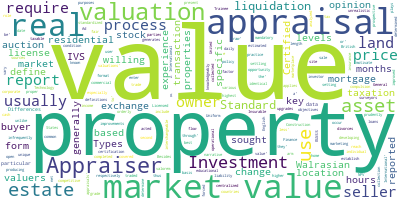

In [67]:
im

# Store documents in vector database

In [68]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

In [70]:
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

C:\Users\andre\anaconda3\envs\ai_exam\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
C:\Users\andre\anaconda3\envs\ai_exam\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [72]:
persist_directory = '../data/chroma/'

vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)
vectordb.persist()

C:\Users\andre\anaconda3\envs\ai_exam\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


In [73]:
vectordb._collection.count()

27

In [74]:
query = 'How can I determine a house value?'

In [75]:
answer = vectordb.similarity_search(query, k=3)
answer

[Document(page_content='various sources to real property to determine taxable value.', metadata={'source': 'https://en.wikipedia.org/wiki/Real_estate_appraisal', 'summary': 'Real estate appraisal, property valuation or land valuation is the process of developing an opinion of value for real property (usually market value). Real estate transactions often require appraisals because they occur infrequently and every property is unique (especially their condition, a key factor in valuation), unlike corporate stocks, which are traded daily and are identical (thus a centralized Walrasian auction like a stock exchange is unrealistic). The location also plays a key role in valuation. However, since property cannot change location, it is often the upgrades or improvements to the home that can change its value. Appraisal reports form the basis for mortgage loans, settling estates and divorces, taxation, and so on. Sometimes an appraisal report is used to establish a sale price for a property.\nB

In [76]:
for d in answer:
    print(d.page_content)

various sources to real property to determine taxable value.
establish a sale price for a property.
Real estate appraisal, property valuation or land valuation is the process of developing an opinion of value for real property (usually market value). Real estate transactions often require appraisals


In [78]:
from langchain.llms import Ollama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

In [79]:
!ollama list

NAME          	ID          	SIZE  	MODIFIED    
mistral:latest	2ae6f6dd7a3d	4.1 GB	12 days ago	


In [80]:
llm = Ollama(model="mistral", callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]))

In [91]:
template = """If you cannot answer the question, say you do not know the answer. Always end with Thanks for asking!
{context}""" 

In [88]:
prompt = PromptTemplate.from_template(template)
chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt})

In [92]:
question = "How much value do you think a small appartment in New York City will go for?"

In [93]:
result = chain({"query": question})
result["result"]

 To establish a sale price for a property, you need to consider factors that influence its market value, such as location, size, age, condition, and current real estate trends in the area. However, it's essential to understand that market value is not the only factor influencing the sale price of a property. Other aspects may include the buyer's and seller's negotiation skills, financing options, and emotional factors like urgency or attachment to the property.

When determining taxable value for a property, various sources can be used, including appraisals, local assessment records, and sales comparisons of similar properties in the area. Taxable value may differ from market value since it is influenced by factors such as local taxes and government policies.

Thanks for asking!

" To establish a sale price for a property, you need to consider factors that influence its market value, such as location, size, age, condition, and current real estate trends in the area. However, it's essential to understand that market value is not the only factor influencing the sale price of a property. Other aspects may include the buyer's and seller's negotiation skills, financing options, and emotional factors like urgency or attachment to the property.\n\nWhen determining taxable value for a property, various sources can be used, including appraisals, local assessment records, and sales comparisons of similar properties in the area. Taxable value may differ from market value since it is influenced by factors such as local taxes and government policies.\n\nThanks for asking!"

In [94]:
question = "How much value do you think my 4 year old appartment in New York City will go for?"

In [95]:
result = chain({"query": question})
result["result"]

 To establish a sale price for a property, it's essential to consider both its market value and any other factors that might influence the selling price. Market value refers to the highest price a buyer would pay and the lowest a seller would accept in an open and unfettered market.

However, the market value is not always the final sale price. Here are some factors that could cause the sale price to deviate from the market value:

1. **Negotiations:** Buyers and sellers can negotiate the price based on various factors like the property's condition, location, or urgency to sell.

2. **Market conditions:** A hot real estate market might lead to bidding wars, pushing prices up. On the other hand, a slow market could mean lower prices due to fewer buyers.

3. **Property improvements:** If the property has undergone renovations or improvements that exceed typical expectations for the neighborhood, it could command a higher price.

4. **Financing options:** If the seller is willing to offer

" To establish a sale price for a property, it's essential to consider both its market value and any other factors that might influence the selling price. Market value refers to the highest price a buyer would pay and the lowest a seller would accept in an open and unfettered market.\n\nHowever, the market value is not always the final sale price. Here are some factors that could cause the sale price to deviate from the market value:\n\n1. **Negotiations:** Buyers and sellers can negotiate the price based on various factors like the property's condition, location, or urgency to sell.\n\n2. **Market conditions:** A hot real estate market might lead to bidding wars, pushing prices up. On the other hand, a slow market could mean lower prices due to fewer buyers.\n\n3. **Property improvements:** If the property has undergone renovations or improvements that exceed typical expectations for the neighborhood, it could command a higher price.\n\n4. **Financing options:** If the seller is willi